<a href="https://www.kaggle.com/code/aleksandrmorozov123/image-manipulations?scriptVersionId=232258999" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

**Convolutional auto-encoder**

In [2]:
!pip install -q torch_snippets
!pip install torchsummary

In [3]:
import torch
import torch.nn as nn
from torch_snippets import *
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST
from torchvision import transforms
from torchsummary import summary
from torch_snippets.torch_loader import Report
import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
img_transform = transforms.Compose ([
    transforms.ToTensor (),
    transforms.Normalize ([0.5], [0.5]),
    transforms.Lambda (lambda x: x.to(device))
])

trn_ds = FashionMNIST ('/kaggle/working', transform = img_transform, train = True, download = True)
val_ds = FashionMNIST ('/kaggle/working', transform = img_transform, train = False, download = True)

batch_size = 128
trn_dl = DataLoader (trn_ds, batch_size = batch_size, shuffle = True)
val_dl = DataLoader (val_ds, batch_size=batch_size, shuffle=False)

100%|██████████| 26421880/26421880 [00:01<00:00, 14017104.01it/s]


Extracting /kaggle/working/FashionMNIST/raw/train-images-idx3-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 206939.76it/s]


Extracting /kaggle/working/FashionMNIST/raw/train-labels-idx1-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3895786.35it/s]


Extracting /kaggle/working/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to /kaggle/working/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 13320343.61it/s]

Extracting /kaggle/working/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to /kaggle/working/FashionMNIST/raw



In [5]:
class ConvAutoEncoder(nn.Module): 
    def __init__(self): 
        super().__init__() 
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, stride=3, padding=1), 
            nn.ReLU(True), nn.MaxPool2d(2, stride=2), 
            nn.Conv2d(32, 64, 3, stride=2, padding=1), 
            nn.ReLU(True), nn.MaxPool2d(2, stride=1) 
        ) 
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 3, stride=2), 
            nn.ReLU(True), 
            nn.ConvTranspose2d(32, 16, 5, stride=3, padding=1), 
            nn.ReLU(True), nn.ConvTranspose2d(16, 1, 2, stride=2, padding=1), 
            nn.Tanh()
        ) 
    def forward(self, x): 
        x = self.encoder(x) 
        x = self.decoder(x) 
        return x
            
model = ConvAutoEncoder().to(device)

In [6]:
def train_batch (input, model, criterion, optimizer):
    model.train ()
    optimizer.zero_grad ()
    output = model (input)
    loss = criterion (output, input)
    loss.backward ()
    optimizer.step ()
    return loss

@torch.no_grad ()
def validate_batch (input, model, criterion):
    model.eval ()
    output = model (input)
    loss = criterion (output, input)
    return loss

model = ConvAutoEncoder().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW (model.parameters(), lr = 0.001, weight_decay = 1e-5)

num_epochs = 5
log = Report (num_epochs)

for epoch in range (num_epochs):
    N = len (trn_dl)
    for ix, (data, _) in enumerate (trn_dl):
        loss = train_batch (data, model, criterion, optimizer)
        log.record (pos = (epoch + (ix + 1)/N), trn_loss = loss, end = '\r')

    N = len(val_dl)
    for ix, (data, _) in enumerate(val_dl): 
        loss = validate_batch(data, model, criterion) 
        log.record(pos=(epoch + (ix+1)/N), val_loss=loss, end='\r')
    log.report_avgs (epoch + 1)

EPOCH: 1.000  val_loss: 0.079  trn_loss: 0.156  (18.25s - 72.99s remaining)
EPOCH: 2.000  val_loss: 0.063  trn_loss: 0.069  (35.56s - 53.34s remaining)
EPOCH: 3.000  val_loss: 0.055  trn_loss: 0.058  (52.89s - 35.26s remaining)
EPOCH: 4.000  val_loss: 0.051  trn_loss: 0.052  (69.96s - 17.49s remaining)
EPOCH: 5.000  val_loss: 0.048  trn_loss: 0.049  (87.29s - 0.00s remaining)


100%|██████████| 106/106 [00:00<00:00, 2032.39it/s]


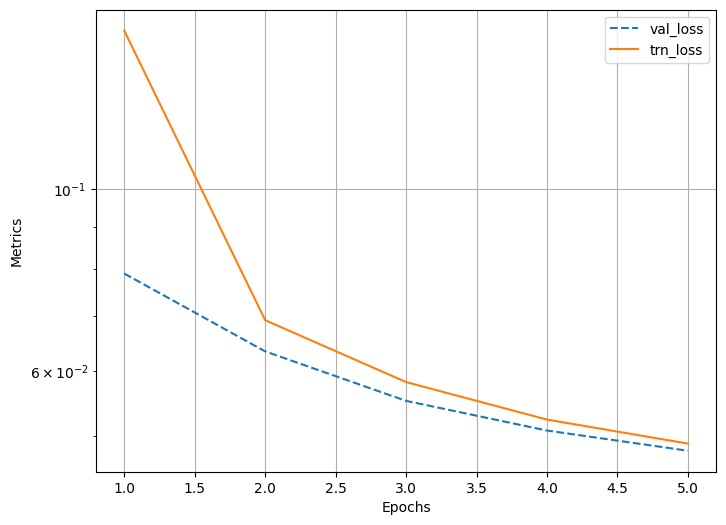

In [7]:
log.plot_epochs (log = True)

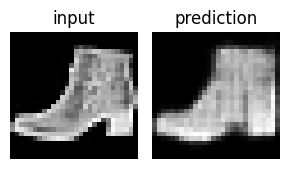

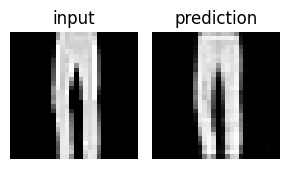

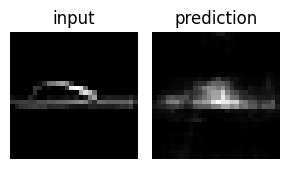

In [8]:
for _ in range (3):
    ix = np.random.randint (len(val_ds))
    im, _ = val_ds[ix]
    _im = model (im[None])[0]
    fig, ax = plt.subplots (1, 2, figsize = (3, 3))
    show (im[0], ax = ax[0], title = 'input')
    show (_im[0], ax = ax[1], title = 'prediction')
    plt.tight_layout()
    plt.show()

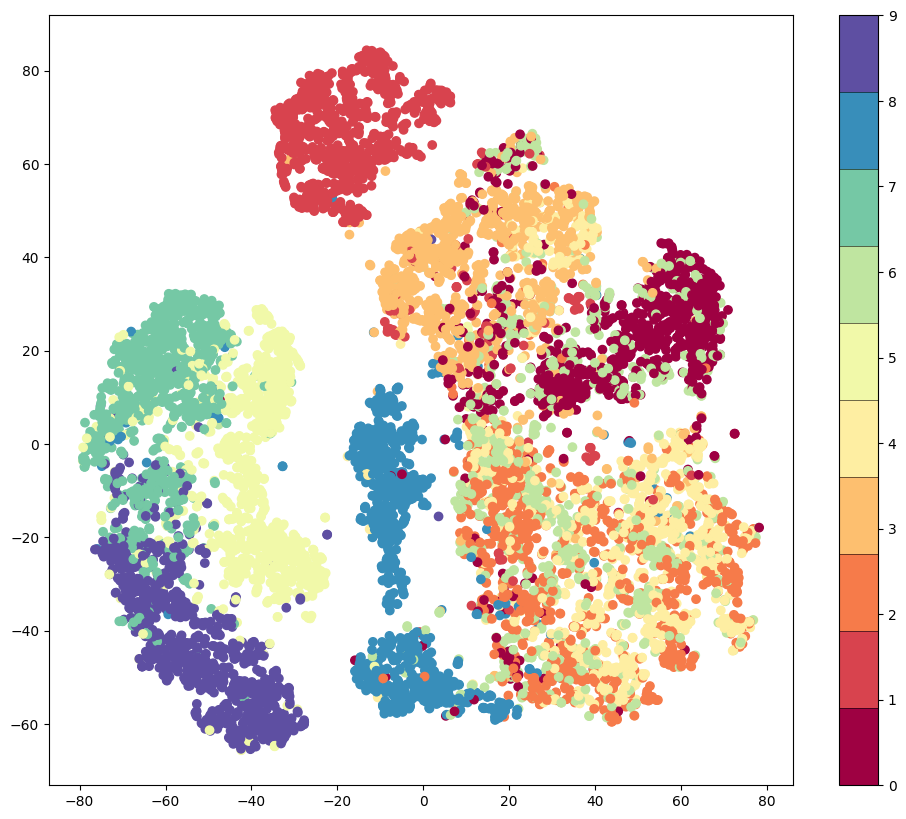

In [9]:
latent_vectors = []
classes = []

for im, clss in val_dl:
    latent_vectors.append (model.encoder(im).view(len(im), -1))
    classes.extend (clss)

latent_vectors = torch.cat (latent_vectors).cpu().detach().numpy()
tsne = TSNE (2)

clustered = tsne.fit_transform (latent_vectors)

fig = plt.figure (figsize = (12, 10))
cmap = plt.get_cmap ('Spectral', 10)
plt.scatter (*zip(*clustered), c=classes, cmap=cmap)
plt.colorbar (drawedges = True)

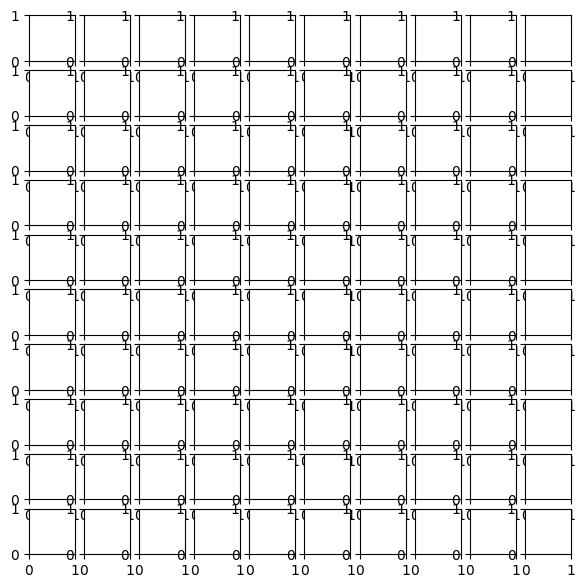

In [10]:
latent_vectors = []
classes = []

for im, clss in val_dl:
    latent_vectors.append (model.encoder (im))
    classes.extend (clss)

latent_vectors = torch.cat (latent_vectors).cpu().detach().numpy().reshape (1000, -1)

rand_vectors = []

for col in latent_vectors.transpose (1, 0):
    mu, sigma = col.mean(), col.std ()
    rand_vectors.append (sigma * torch.randn (1, 100) + mu)

rand_vectors = torch.cat (rand_vectors).transpose (1, 0).to(device)
fig, ax = plt.subplots (10, 10, figsize = (7, 7))
ax = iter (ax.flat)

# for p in rand_vectors:
#     img = model.decoder (p.reshape (1, 2560, 2, 2)).view (28, 28)
#     show (img, ax = next(ax))